In [1]:
import pandas as pd
import os

df = pd.read_json(os.path.abspath("..\\..\\benchmark\\benchmark_v2\\benchmark_v2.json"))
df

,text
Chinese Remainder Theorem,[Solving $x \equiv 2 \mod 3$ and $x \equiv 3 \...
Diophantine Equations,[Solving $3x + 5y = 1$ using the extended Eucl...
Divisibility,[From (1) it follows that $A(x_{1}+y_{1})=p^{k...
Euler’s Theorem,"[By Euler’s Theorem, $10^{\varphi(f k)}\equiv1..."
Extremal Principles,"[If $x\geq3$ , $y\geq3$ , $z\geq3$ then $x y z..."
Fermat’s Little Theorem,[The formula in our problem shows that the sum...
Modular Arithmetics,[Assume that we have a prime $p$ such that $p|...
Pigeonhole Principle,[Let $S$ be the set of nonnegative integers le...
Prime Numbers,[Assume that we have a prime $p$ such that $p|...
Quadratic Residues,"[If $n$ is even, then $p\equiv3$ (mod 4) and $..."


In [2]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

df = df.explode("text").reset_index().rename({"index": "label"}, axis=1)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "eval": test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 80
    })
    eval: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 20
    })
})

In [3]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
model = BertModel.from_pretrained("tbs17/MathBERT")
device = torch.device("cuda")
model = model.to(device)

In [4]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    texts = [item['text'] for item in batch]
    encoding = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    return {'input_ids': encoding['input_ids'], 'attention_mask': encoding['attention_mask']}

train_dataloader = DataLoader(dataset['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
eval_dataloader = DataLoader(dataset['eval'], batch_size=16, collate_fn=collate_fn)

## GPT guide

In [5]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
import random

tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
bert = BertModel.from_pretrained("tbs17/MathBERT")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = bert.to(device)

In [6]:
clusters = {
    0: ["Use distributive law", "Apply a(b + c) = ab + ac"],
    1: ["Subtract both sides", "Eliminate by subtraction"],
    2: ["Combine like terms", "Group similar variables"],
    # ... up to cluster 9
}

In [7]:
def make_pairs(clusters):
    pairs = []
    labels = []

    # Positive pairs (same cluster)
    for cluster in clusters.values():
        for i in range(len(cluster)):
            for j in range(i + 1, len(cluster)):
                pairs.append((cluster[i], cluster[j]))
                labels.append(1)

    # Negative pairs (different clusters)
    cluster_keys = list(clusters.keys())
    for _ in range(len(pairs)):
        c1, c2 = random.sample(cluster_keys, 2)
        t1 = random.choice(clusters[c1])
        t2 = random.choice(clusters[c2])
        pairs.append((t1, t2))
        labels.append(0)
    
    return pairs, labels


In [8]:
def encode(text, tokenizer):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = bert(**tokens)
    return outputs.last_hidden_state[:, 0, :]  # [CLS] token


In [9]:
class ContrastiveModel(nn.Module):
    def __init__(self, encoder, tokenizer):
        super().__init__()
        self.encoder = encoder
        self.tokenizer = tokenizer
        self.projection = nn.Linear(encoder.config.hidden_size, 128)

    def forward(self, x1, x2):
        z1 = self.projection(encode(x1, self.tokenizer))
        z2 = self.projection(encode(x2, self.tokenizer))
        return z1, z2


In [10]:
def train(model, clusters, epochs=2):
    pairs, labels = make_pairs(clusters)
    criterion = nn.CosineEmbeddingLoss(margin=0.5)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for (t1, t2), label in zip(pairs, labels):
            z1, z2 = model(t1, t2)
            target = torch.tensor([1.0 if label == 1 else -1.0], device=device)
            loss = criterion(z1, z2, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

In [11]:
model = ContrastiveModel(bert, tokenizer).to(device)
train(model, clusters)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1, Loss: 1.5187
Epoch 2, Loss: 1.3850


In [14]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter

def get_embeddings(model, tokenizer, texts, device, batch_size=32):
    """
    Returns a (N, D) array of projection-head embeddings for a list of texts.
    """
    model.eval()
    embeds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            toks  = tokenizer(batch,
                              return_tensors='pt',
                              padding=True,
                              truncation=True,
                              max_length=128).to(device)
            # get [CLS] hidden state
            h = model.encoder(**toks).last_hidden_state[:, 0, :]    # (B, H)
            z = model.projection(h)                                # (B, D)
            embeds.append(z.cpu().numpy())
    return np.vstack(embeds)  # (N, D)

def test_clustering_performance(model, tokenizer, clusters, device):
    """
    clusters: dict[int, List[str]] mapping true cluster id → list of texts
    Returns: dict with ARI, NMI, Purity
    """
    # 1) flatten texts & labels
    texts, true_labels = [], []
    for cid, docs in clusters.items():
        texts.extend(docs)
        true_labels.extend([cid] * len(docs))
    true_labels = np.array(true_labels)

    # 2) get embeddings
    X = get_embeddings(model, tokenizer, texts, device)

    # 3) K-Means
    kmeans = KMeans(n_clusters=len(clusters), random_state=42)
    pred_labels = kmeans.fit_predict(X)

    # 4) metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)

    # 5) purity
    # for each predicted cluster, find the most common true label
    total = len(texts)
    correct = 0
    for pid in np.unique(pred_labels):
        mask = pred_labels == pid
        true_in_cluster = true_labels[mask]
        most_common = Counter(true_in_cluster).most_common(1)[0][1]
        correct += most_common
    purity = correct / total

    return {
        "ARI": ari,
        "NMI": nmi,
        "Purity": purity
    }


In [12]:
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, tokenizer, clusters, device,
                           batch_size=32, pca_components=2,
                           random_state=42):
    """
    clusters: dict[int, List[str]] mapping true cluster → list of texts
    Returns:
      metrics: dict with 'ARI', 'NMI', 'Purity'
      fig: matplotlib.figure.Figure showing 2D scatter of embeddings
    """
    # 1) flatten texts & labels
    texts, true_labels = [], []
    for cid, docs in clusters.items():
        texts.extend(docs)
        true_labels.extend([cid] * len(docs))
    true_labels = np.array(true_labels)

    # 2) get embeddings (using your get_embeddings helper)
    X = get_embeddings(model, tokenizer, texts, device, batch_size)  # shape (N, D)

    # 3) K-Means clustering
    kmeans = KMeans(n_clusters=len(clusters), random_state=random_state)
    pred_labels = kmeans.fit_predict(X)

    # 4) compute metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    # purity
    total = len(texts)
    correct = 0
    for pid in np.unique(pred_labels):
        mask = pred_labels == pid
        most_common = Counter(true_labels[mask]).most_common(1)[0][1]
        correct += most_common
    purity = correct / total

    metrics = {"ARI": ari, "NMI": nmi, "Purity": purity}

    # 5) PCA to 2D
    pca = PCA(n_components=pca_components, random_state=random_state)
    coords = pca.fit_transform(X)  # shape (N, 2)

    # 6) plot
    fig, ax = plt.subplots(figsize=(6,6))
    scatter = ax.scatter(coords[:,0], coords[:,1],
                         c=true_labels,
                         cmap='tab10',
                         alpha=0.7,
                         edgecolors='k')
    ax.set_title("2D PCA of Strategy Embeddings")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    legend1 = ax.legend(*scatter.legend_elements(),
                        title="True Cluster",
                        loc="upper right",
                        bbox_to_anchor=(1.25, 1))
    ax.add_artist(legend1)
    plt.tight_layout()

    return metrics, fig


In [17]:
def visualize_interactive(model, tokenizer, clusters, device='cpu', batch_size=32, pca_components=2):
    """
    Computes embeddings for each text in clusters on CPU, reduces to 2D, and
    returns an interactive Plotly scatter plot with hover information.
    """
    # 1) flatten texts & labels
    texts, true_labels = [], []
    for cid, docs in clusters.items():
        texts.extend(docs)
        true_labels.extend([cid] * len(docs))
    true_labels = np.array(true_labels)
    
    # 2) get embeddings (reuse existing helper, forcing CPU)
    X = get_embeddings(model, tokenizer, texts, device='cpu', batch_size=batch_size)
    
    # 3) PCA to 2D
    pca = PCA(n_components=pca_components, random_state=42)
    coords = pca.fit_transform(X)  # shape (N, 2)
    
    # 4) build dataframe for Plotly
    df = pd.DataFrame({
        'PC1': coords[:, 0],
        'PC2': coords[:, 1],
        'cluster': true_labels.astype(str),
        'text': texts
    })
    
    # 5) create interactive plot
    fig = px.scatter(
        df,
        x='PC1',
        y='PC2',
        color='cluster',
        hover_data=['text'],
        title="Interactive 2D PCA of Strategy Embeddings"
    )
    fig.update_layout(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        legend_title="True Cluster"
    )
    fig.show()
    return fig

ARI:    0.4444
NMI:    0.7397
Purity: 0.8333


C:\Users\mokrota\AppData\Local\Temp\ipykernel_41620\1963297986.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()   # or plt.show()


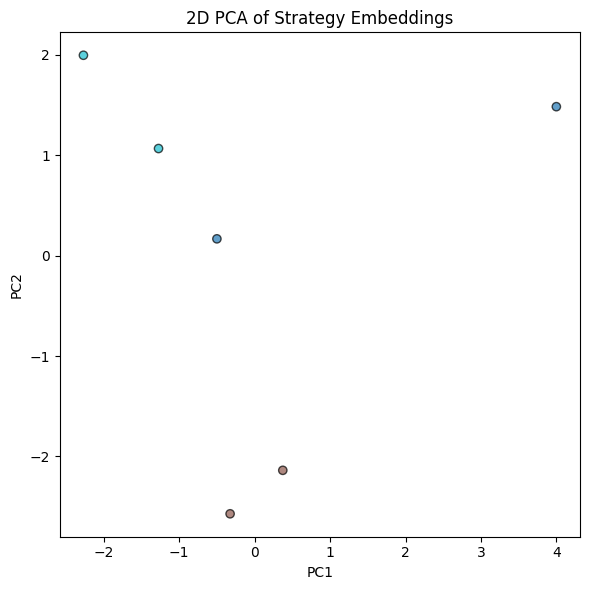

In [15]:
metrics, fig = evaluate_and_visualize(model, tokenizer, clusters, device)
print(f"ARI:    {metrics['ARI']:.4f}")
print(f"NMI:    {metrics['NMI']:.4f}")
print(f"Purity: {metrics['Purity']:.4f}")
fig.show()   # or plt.show()


## Try for my model

In [32]:
tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
bert = BertModel.from_pretrained("tbs17/MathBERT")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = bert.to(device)

In [33]:
clusters = {}
for row in df.iterrows():
    label = row[1]['label']
    text = row[1]['text']
    clusters[label] = clusters.get(label, [])
    clusters[label].append(text)

In [34]:
model = ContrastiveModel(bert, tokenizer).to(device)
train(model, clusters, epochs=10)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1, Loss: 200.0334
Epoch 2, Loss: 212.3310
Epoch 3, Loss: 213.2060


KeyboardInterrupt: 